In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
latent_dim = 100
# 생성자
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러개의 block을 쌓아서 만들어짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1*28*28),
            nn.Tanh() 
        )

    def forward(self, z): 
        # z : input noise vector 
        img = self.model(z)
        # 이미지 형태로 만들어줌
        img = img.view(img.size(0), 1, 28, 28) # 배치 사이즈, 채널, 넓이, 높이
        return img

In [4]:
# 판별자(Disciminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1*28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(), # 확률값을 내보냄
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        validity = self.model(flattened)

        return validity

In [5]:
# 학습 데이터셋 불러오기
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(), # data를 pytorch의 tensor형식으로 바꿉니다
    transforms.Normalize([0.5], [0.5]) # 픽셀값을 0 ~ 1에서 -1 ~ 1 로 바꿔줍니다.
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [10]:
# 생성자, 판별자 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률 설정
lr = 0.0002

# 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [12]:
import time

n_epochs = 200 
sample_interval = 2000 # 몇번의 배치마다 결과를 출력할 것인지 설정

start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        ## 실제 이미지는 1로, 가짜 이미지는 0으로 label됩니다. 
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.cuda()

        # -----------------
        #  생성자 학습
        # -----------------

        optimizer_G.zero_grad()

        # 랜덤 노이즈 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        ## random sampling한 값인 z를 생성자에 넣어 이미지를 생성합니다.
        generated_imgs = generator(z)

        # 생성자의 손실값 계산
        ## 생성된 이미지를 discriminator가 판별하게 한 후, loss값을 계산합니다.
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  판별자 학습
        # ---------------------

        optimizer_D.zero_grad()

        # 판별자 손실 값 계산
        ## 실제 이미지는 real(1)로, 가짜 이미지는 fake(0)으로 판별하도록 계산합니다.
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"data{epoch}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.523001] [G loss: 0.584334] [Elapsed time: 8.54s]
[Epoch 1/200] [D loss: 0.443812] [G loss: 1.423323] [Elapsed time: 16.94s]
[Epoch 2/200] [D loss: 0.273452] [G loss: 1.538324] [Elapsed time: 25.61s]
[Epoch 3/200] [D loss: 0.362887] [G loss: 0.865044] [Elapsed time: 33.99s]
[Epoch 4/200] [D loss: 0.482733] [G loss: 1.903736] [Elapsed time: 42.36s]
[Epoch 5/200] [D loss: 0.369711] [G loss: 2.330193] [Elapsed time: 50.80s]
[Epoch 6/200] [D loss: 0.224206] [G loss: 2.247352] [Elapsed time: 59.24s]
[Epoch 7/200] [D loss: 0.202110] [G loss: 1.760058] [Elapsed time: 67.72s]
[Epoch 8/200] [D loss: 0.343543] [G loss: 0.919348] [Elapsed time: 76.14s]
[Epoch 9/200] [D loss: 0.270845] [G loss: 1.315881] [Elapsed time: 84.57s]
[Epoch 10/200] [D loss: 0.285356] [G loss: 0.919849] [Elapsed time: 93.01s]
[Epoch 11/200] [D loss: 0.181217] [G loss: 3.525651] [Elapsed time: 101.36s]
[Epoch 12/200] [D loss: 0.377907] [G loss: 4.849874] [Elapsed time: 109.86s]
[Epoch 13/200] [D los

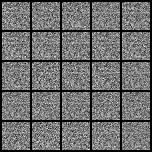

In [26]:
from IPython.display import Image
Image(f'data0.png')

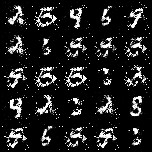

In [28]:
Image(f'data51.png')

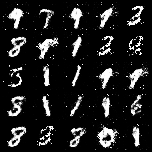

In [30]:
Image(f'data102.png')

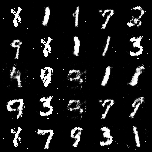

In [31]:
Image(f'data153.png')

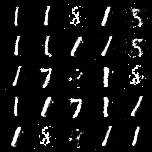

In [33]:
Image(f'data196.png')